In [1]:
import sys

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

In [3]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

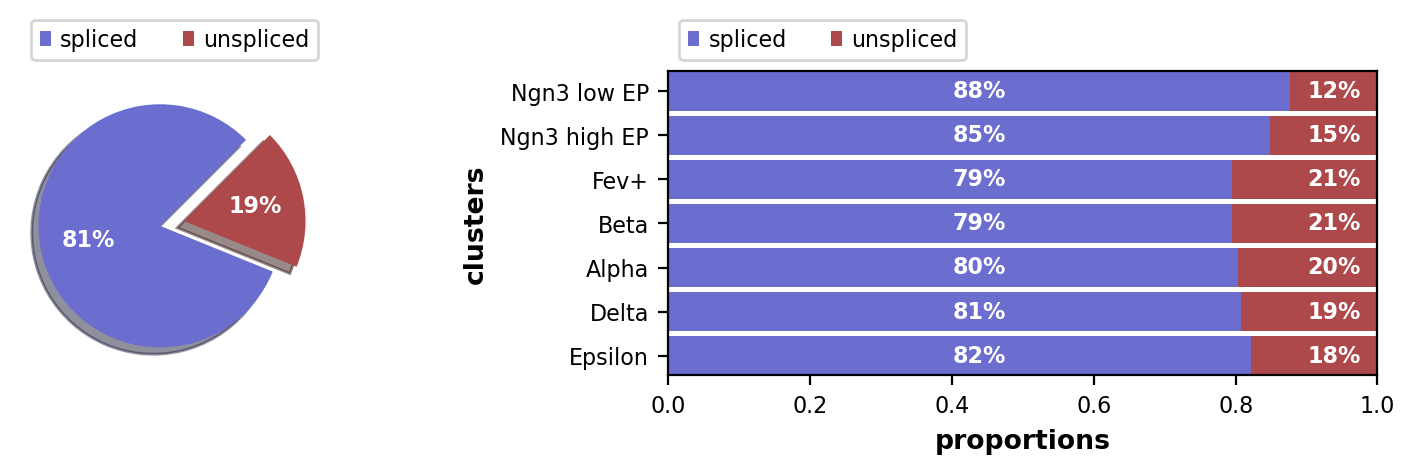

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [4]:
adata = cr.datasets.pancreas()
scv.pl.proportions(adata)
adata

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)


Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
scv.tl.recover_dynamics(adata, n_jobs=16)

recovering dynamics (using 16/76 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:47) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [7]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/76 cores)
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


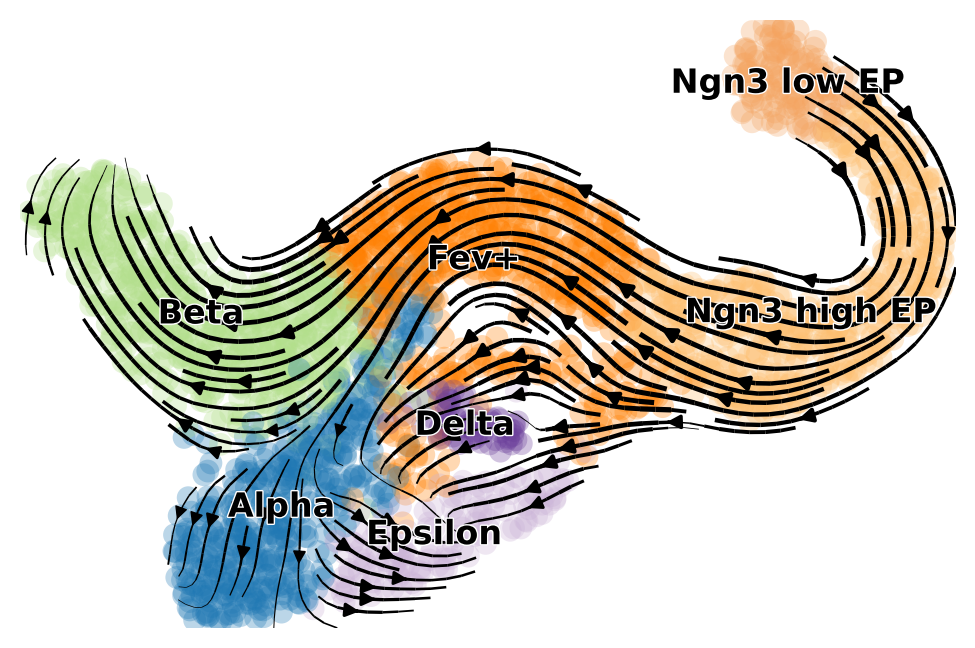

In [8]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=12, title="", smooth=0.8, min_mass=4
)

In [9]:
# run cellRank 
# it did not work well, see issue in https://github.com/theislab/cellrank/issues/399
# cr.tl.terminal_states(adata, cluster_key="clusters", weight_connectivities=0.2)

In [10]:
from cellrank.tl.kernels import VelocityKernel

vk = VelocityKernel(adata)

In [11]:
print(vk)

<VelocityKernel>


In [12]:
# Compute a transition matrix
vk.compute_transition_matrix()

Computing transition matrix based on logits using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode


100%|██████████| 2531/2531 [00:03<00:00, 655.14cell/s]


Setting `softmax_scale=3.7951`


100%|██████████| 2531/2531 [00:03<00:00, 693.80cell/s]


    Finish (0:00:08)


<VelocityKernel>

In [13]:
print(vk)

<VelocityKernel[softmax_scale=3.8, mode=deterministic, seed=44219, scheme=<CorrelationScheme>]>


In [14]:
# Combining two kernels
from cellrank.tl.kernels import ConnectivityKernel

ck = ConnectivityKernel(adata).compute_transition_matrix()

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


In [15]:
combined_kernel = 0.8 * vk + 0.2 * ck

In [16]:
print(combined_kernel)

((0.8 * <VelocityKernel[softmax_scale=3.8, mode=deterministic, seed=44219, scheme=<CorrelationScheme>]>) + (0.2 * <ConnectivityKernel[dnorm=True, key=connectivities]>))


In [17]:
# Initialize an estimator
from cellrank.tl.estimators import GPCCA

g = GPCCA(combined_kernel)
print(g)

GPCCA[n=2531, kernel=((0.8 * <VelocityKernel[softmax_scale=3.8, mode=deterministic, seed=44219, scheme=<CorrelationScheme>]>) + (0.2 * <ConnectivityKernel[dnorm=True, key=connectivities]>))]


Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[6, 10, 13, 16, 19]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:09)


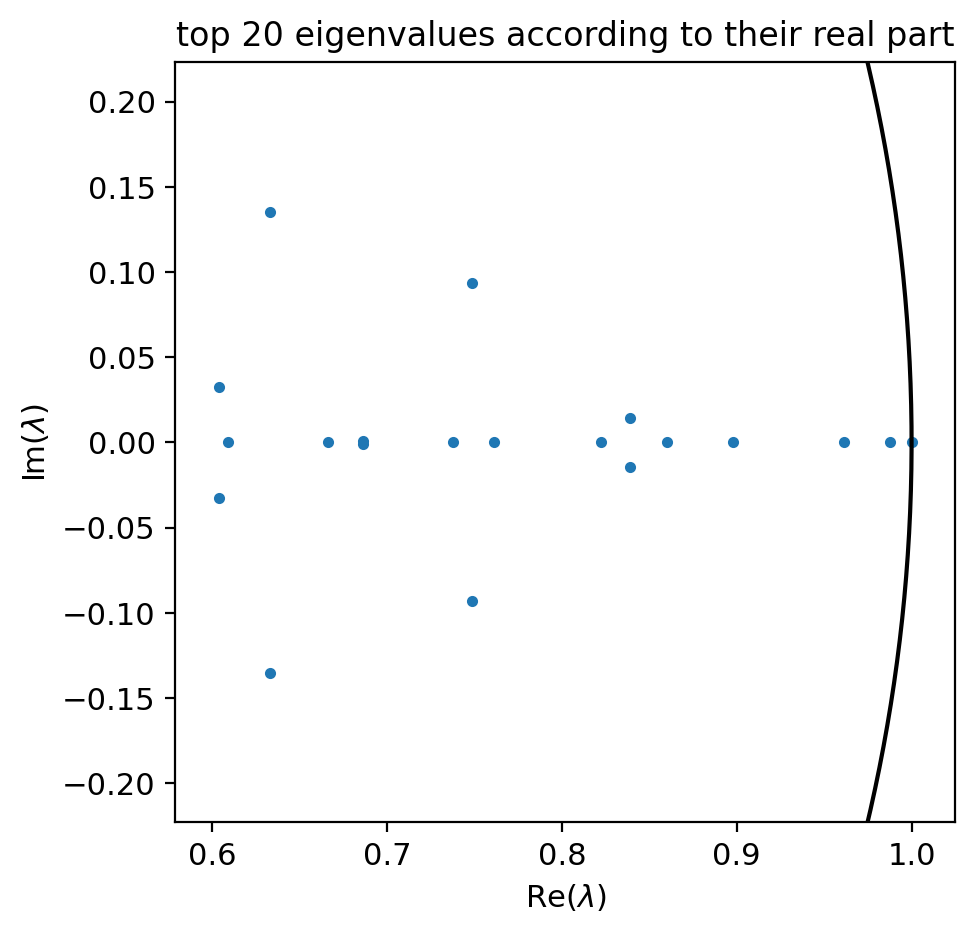

In [18]:
# Compute a matrix decomposition
g.compute_schur(n_components=20, method='brandts') # method with 'brandts', otherwise kernel will be killed
g.plot_spectrum()

Computing `3` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


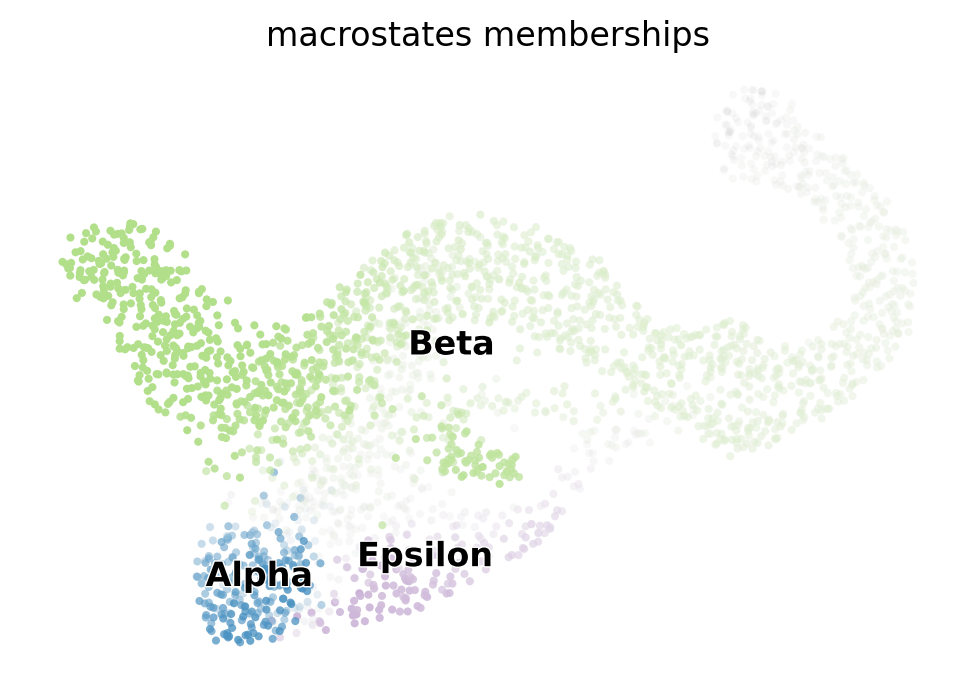

In [19]:
# Infer terminal states
g.compute_macrostates(n_states=3, cluster_key="clusters")
g.plot_macrostates()

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/cellrank.py3.9/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


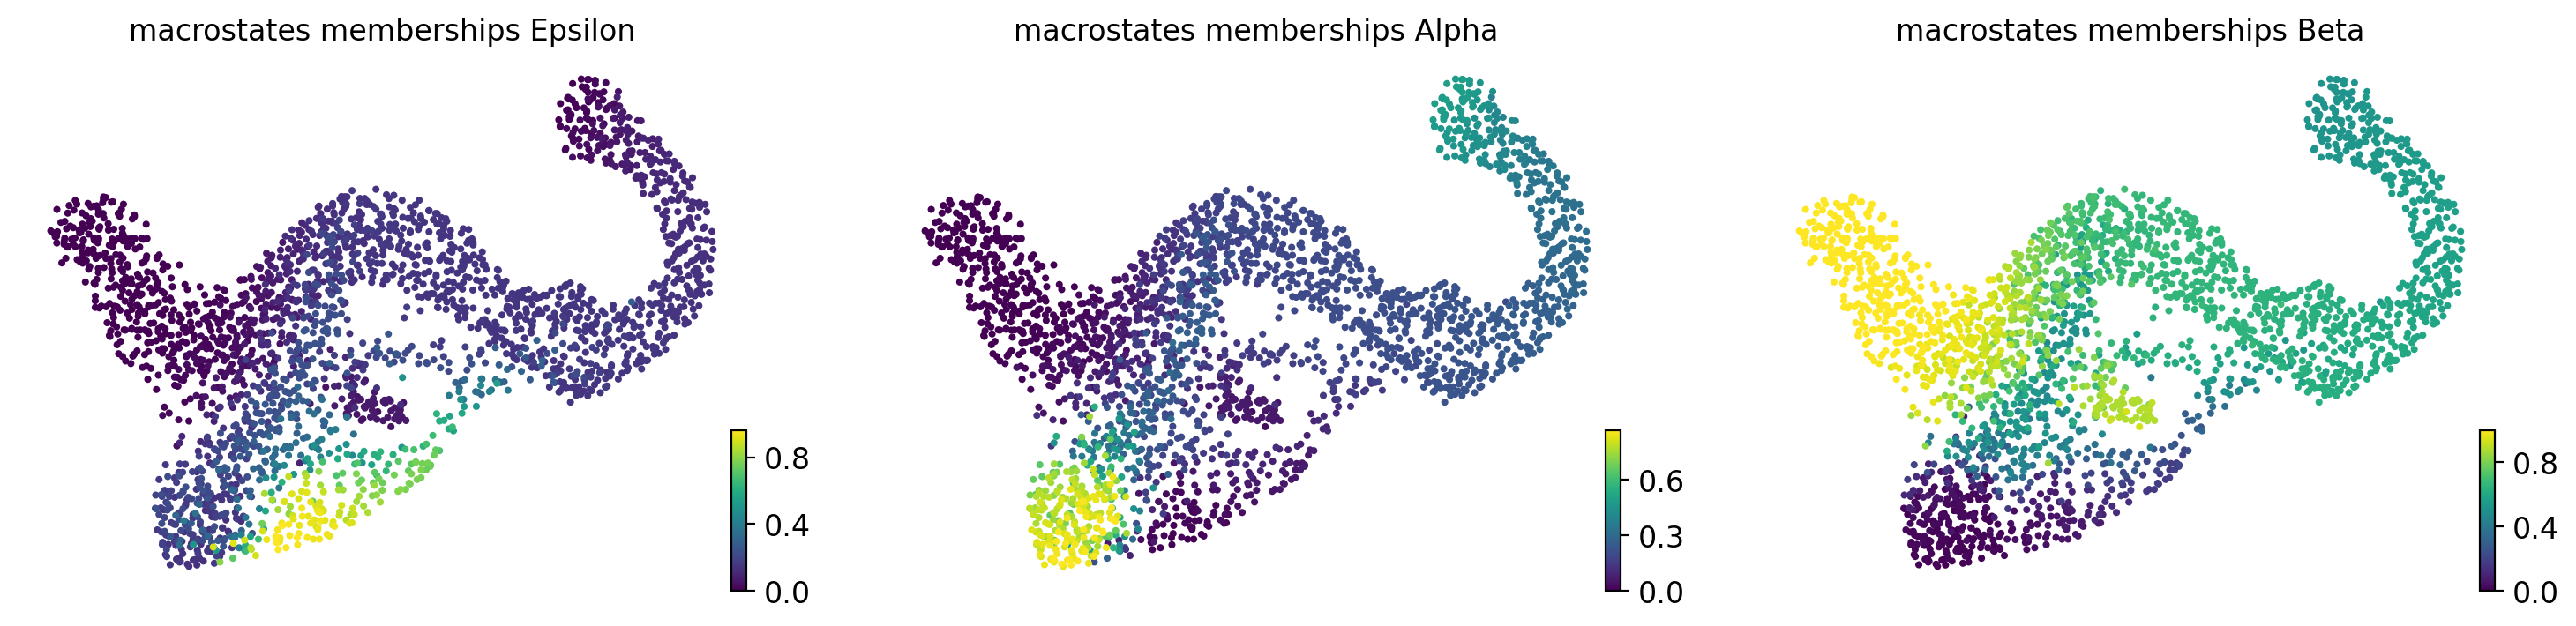

In [20]:
g.plot_macrostates(same_plot=False)

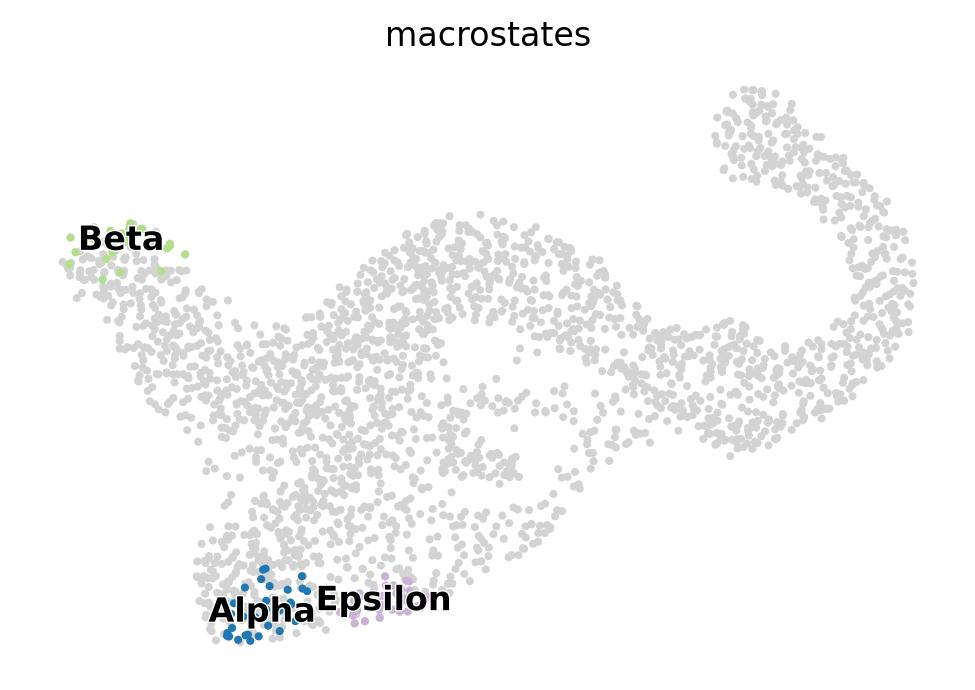

In [21]:
g.plot_macrostates(discrete=True)

In [22]:
g.compute_terminal_states()

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


In [23]:
g.compute_absorption_probabilities(use_petsc = False) # don't use petsc because this dependency doesn't work


Computing absorption probabilities


100%|██████████| 3/3 [00:00<00:00, 28.30/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


In [24]:
adata

AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'clusters_gradients', 'terminal_states', 'terminal_states_probs'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'coa

In [25]:
# find driver genes
alpha_drivers = g.compute_lineage_drivers(lineages="Alpha", return_drivers=True)
alpha_drivers.sort_values(by="Alpha_corr", ascending=False)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


,Alpha_corr,Alpha_pval,Alpha_qval,Alpha_ci_low,Alpha_ci_high
index,,,,,
Gcg,0.860515,0.000000e+00,0.000000e+00,0.850053,0.870298
Irx2,0.517187,3.359753e-182,3.359753e-179,0.488060,0.545163
Peg10,0.516978,5.076105e-182,3.384070e-179,0.487843,0.544963
Wnk3,0.478923,1.380206e-151,6.901032e-149,0.448327,0.508399
Tmsb15l,0.449982,3.624796e-131,1.449918e-128,0.418355,0.480520
...,...,...,...,...,...
Nkx6-1,-0.318417,8.753704e-62,8.753704e-60,-0.352999,-0.282965
Nnat,-0.324287,3.462241e-64,4.073225e-62,-0.358716,-0.288976
Gng12,-0.330585,7.893811e-67,9.867264e-65,-0.364847,-0.295428


/groups/tanaka/People/current/jiwang/local/anaconda3/envs/cellrank.py3.9/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


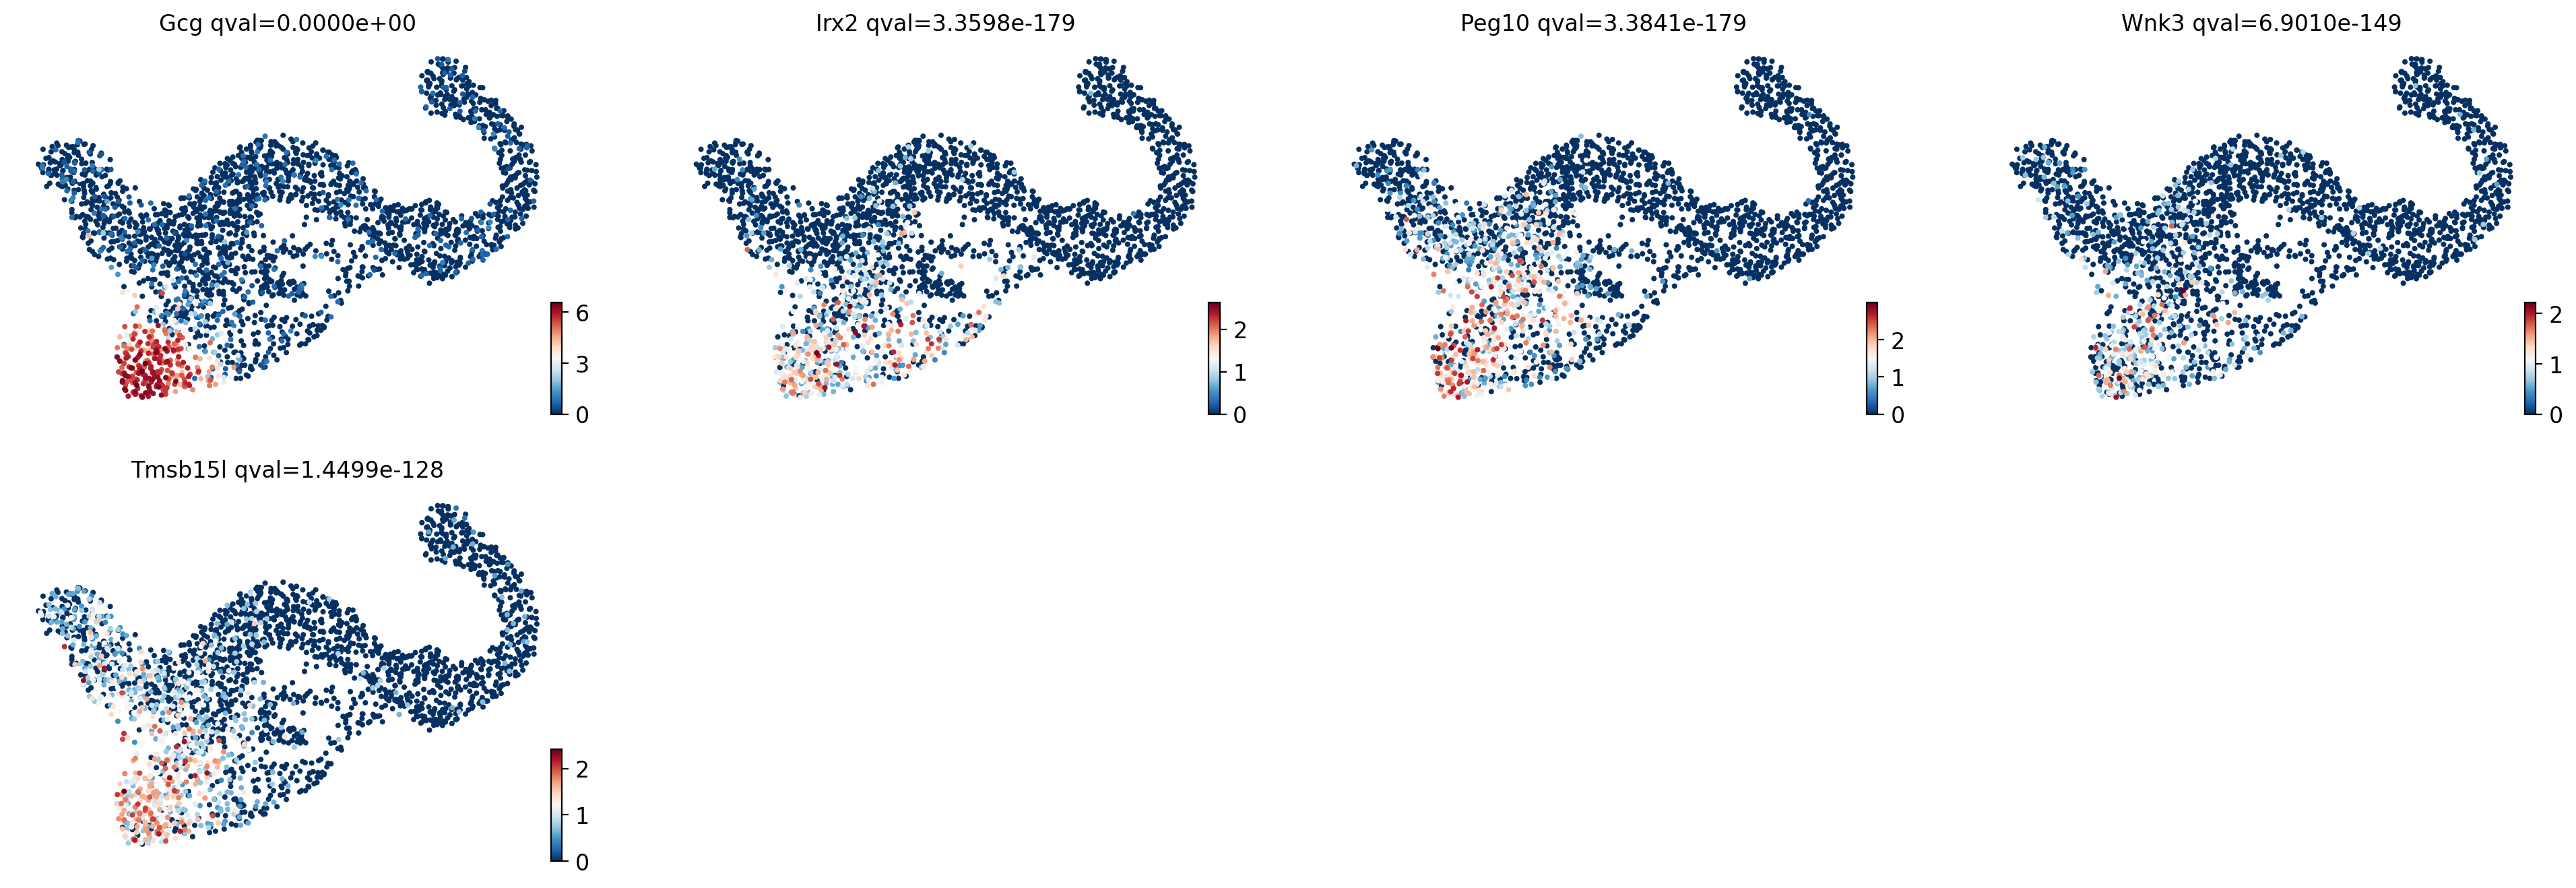

In [27]:
g.plot_lineage_drivers("Alpha", n_genes=5)

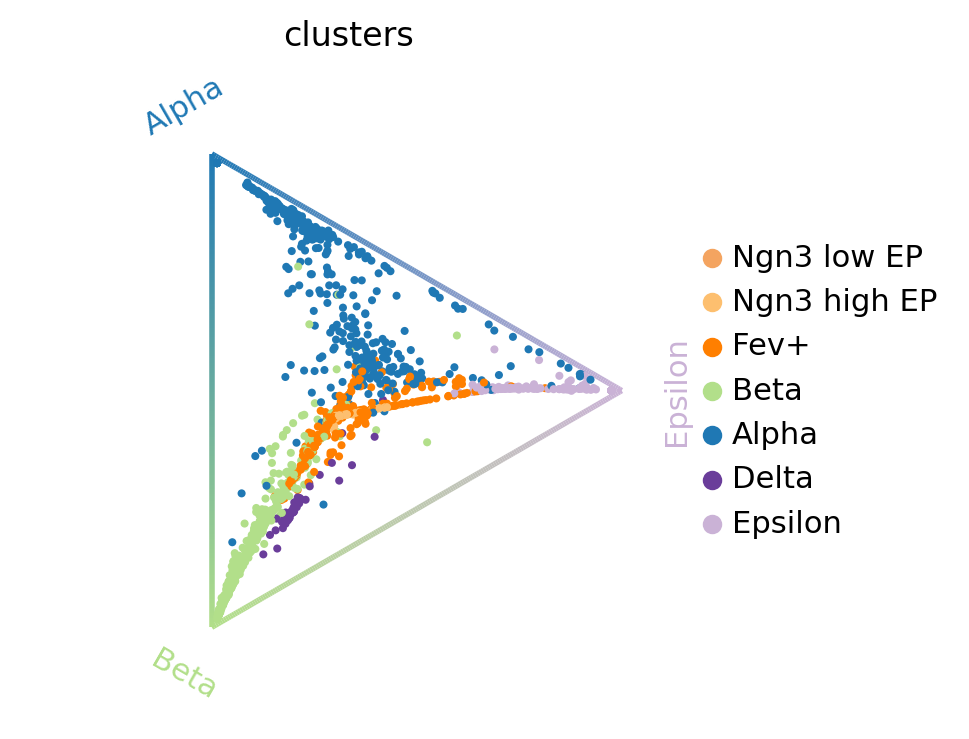

In [28]:
# Use a downstream plotting function
cr.pl.circular_projection(adata, keys="clusters", legend_loc="right")